In [7]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/MyDrive/PlantVillage')


In [ ]:
!unzip your_zip_folder.zip


unzip:  cannot find or open your_zip_folder.zip, your_zip_folder.zip.zip or your_zip_folder.zip.ZIP.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras import models,layers

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 1 1 1 0 1 2 0 0 2 0 0 0 0 1 1 1 0 0 1 0 1 2 0 1 0 0 1 0 0 2]


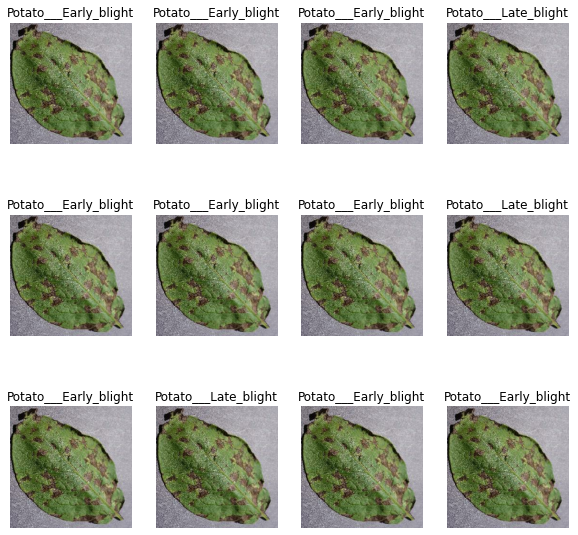

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[0].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])

In [8]:
dataset.take(10) #first 10 sample
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [9]:
train_ds  = dataset.take(54)
len(train_ds)

54

In [10]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [11]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [12]:
val_ds = test_ds.take(6) #validation dataset
len(val_ds)

6

In [13]:

test_ds = test_ds.skip(6)
len(test_ds)

8

In [14]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed =12)
    train_size = int(train_split* ds_size)
    val_size = int(val_split*ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

54

In [17]:
len(val_ds)

6

In [18]:
len(test_ds)

8

In [19]:
'''tarin_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)'''


import tensorflow as tf

# Replace train_ds, val_ds, and test_ds with your actual dataset objects
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [20]:
risize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [21]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [22]:
#CNN
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    risize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),
])
model.build(input_shape = input_shape)


In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)         

In [24]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [27]:
history =  model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds

)

Epoch 1/50
54/54 [==============================] - 43s 795ms/step - loss: 0.9228 - accuracy: 0.4711 - val_loss: 0.8642 - val_accuracy: 0.4479
Epoch 2/50
54/54 [==============================] - 26s 490ms/step - loss: 0.7482 - accuracy: 0.6383 - val_loss: 0.5566 - val_accuracy: 0.7344
Epoch 3/50
54/54 [==============================] - 44s 812ms/step - loss: 0.4748 - accuracy: 0.7940 - val_loss: 0.4355 - val_accuracy: 0.8333
Epoch 4/50
54/54 [==============================] - 91s 2s/step - loss: 0.3177 - accuracy: 0.8819 - val_loss: 0.2929 - val_accuracy: 0.9062
Epoch 5/50
54/54 [==============================] - 133s 2s/step - loss: 0.2336 - accuracy: 0.9126 - val_loss: 0.2655 - val_accuracy: 0.9010
Epoch 6/50
54/54 [==============================] - 125s 2s/step - loss: 0.2685 - accuracy: 0.8900 - val_loss: 0.2098 - val_accuracy: 0.9062
Epoch 7/50
54/54 [==============================] - 124s 2s/step - loss: 0.1823 - accuracy: 0.9277 - val_loss: 0.3013 - val_accuracy: 0.9115
Epoch 8/

In [28]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 1s 103ms/step - loss: 0.0114 - accuracy: 0.9922


In [29]:
scores

[0.011377349495887756, 0.9921875]

In [30]:
history

In [31]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [32]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [33]:
history.history['val_accuracy']

[0.4479166567325592,
 0.734375,
 0.8333333134651184,
 0.90625,
 0.9010416865348816,
 0.90625,
 0.9114583134651184,
 0.9166666865348816,
 0.9583333134651184,
 0.9427083134651184,
 0.9635416865348816,
 0.96875,
 0.9375,
 0.9427083134651184,
 0.90625,
 0.8854166865348816,
 0.9895833134651184,
 0.9895833134651184,
 0.984375,
 0.9583333134651184,
 0.9739583134651184,
 0.9895833134651184,
 0.9947916865348816,
 0.8489583134651184,
 0.96875,
 0.984375,
 0.9895833134651184,
 0.9947916865348816,
 0.984375,
 0.96875,
 0.984375,
 0.9947916865348816,
 0.9010416865348816,
 0.96875,
 0.953125,
 0.9947916865348816,
 0.9739583134651184,
 0.9479166865348816,
 0.9635416865348816,
 0.9739583134651184,
 0.96875,
 1.0,
 0.9895833134651184,
 0.984375,
 0.9635416865348816,
 0.984375,
 0.9791666865348816,
 1.0,
 0.96875,
 1.0]

In [34]:
len(history.history['val_accuracy'])

50

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

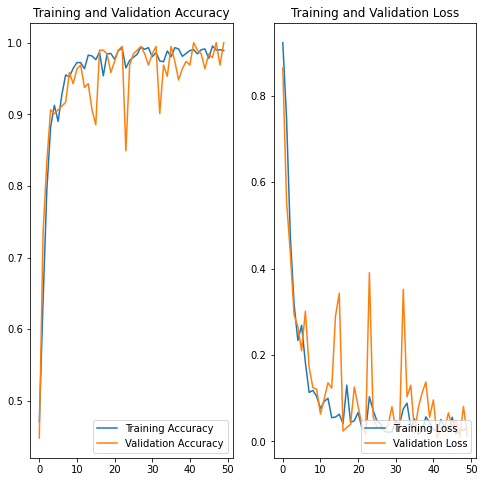

In [36]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc , label = "Training Accuracy")
plt.plot(range(EPOCHS), val_acc , label = "Validation Accuracy")
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss , label = "Training Loss")
plt.plot(range(EPOCHS), val_loss , label = "Validation Loss")
plt.legend(loc = 'lower right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
first image's actual label: Potato___Early_blight
[1.0000000e+00 1.0672815e-08 5.2923047e-19]
Predicted_label: Potato___Early_blight


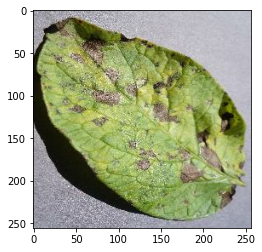

In [37]:
for image_batch, labels_batch in test_ds.take(1):
  first_image = image_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0]
  print("first image to predict")
  plt.imshow(first_image)
  print("first image's actual label:",class_names[first_label])

  batch_prediction = model.predict(image_batch)
  print(batch_prediction[0])
  print("Predicted_label:",class_names[np.argmax(batch_prediction[0])])

In [38]:
np.argmax([9.9999905e-01 ,9.8931798e-07, 9.6477791e-20])

0

In [39]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0)
  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])),2)
  return predicted_class, confidence

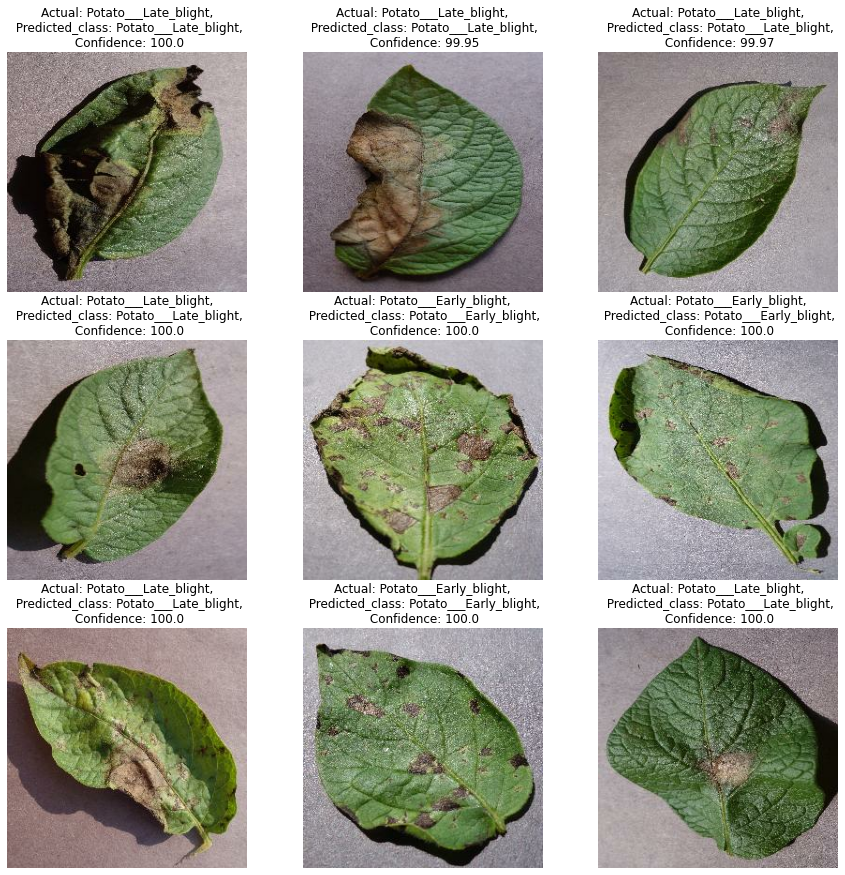

In [40]:
plt.figure(figsize = (15,15))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    predicted_class,confidence = predict(model,images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual: {actual_class},\n Predicted_class: {predicted_class},\n Confidence: {confidence}" )
    plt.axis("off")


In [41]:
model_version = 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets
